In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import operator

def show(image, color=None, title="image"):
    plt.figure(figsize = (10, 10))
    plt.title(title)
    plt.imshow(image, "gray")
    plt.show()
    

In [2]:
image_name = 'receipt_clean.png'
original = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)

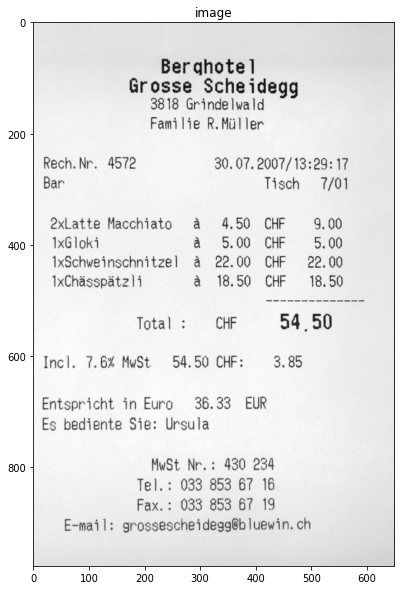

In [3]:
show(original)

In [4]:
blurred = cv2.GaussianBlur(original, (15, 15), 0)

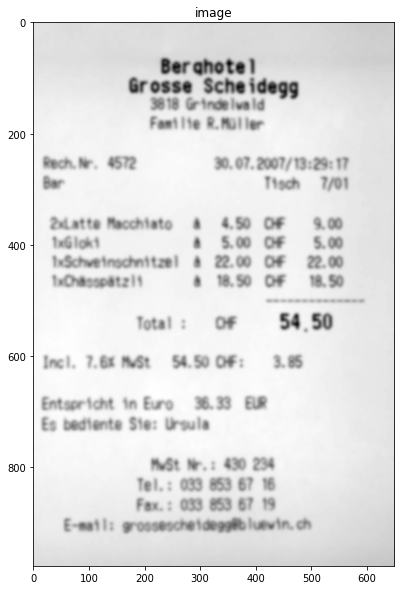

In [5]:
show(blurred)

In [6]:
th1 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

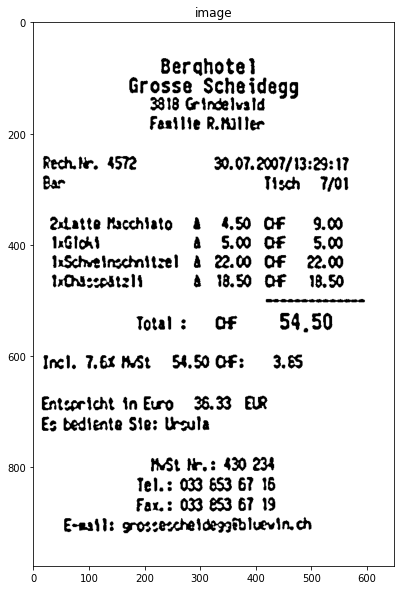

In [7]:
show(th1)

In [8]:
# bitwise_not changes image given as argument!
inverted = cv2.bitwise_not(th1.copy(), th1.copy())

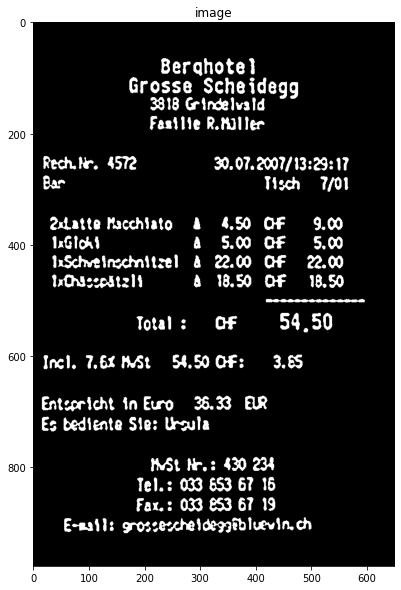

In [9]:
show(inverted)

In [10]:
kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
dilated = cv2.dilate(inverted, kernel)

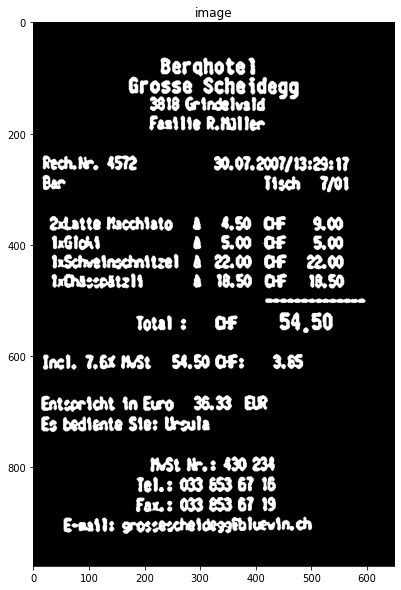

In [11]:
show(dilated)

In [12]:
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [13]:
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    print(cv2.contourArea(contours[0]))

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right = np.array([pt[0][0] + pt[0][1] for pt in polygon]).argmax()
    top_left = np.array([pt[0][0] + pt[0][1] for pt in polygon]).argmin()
    bottom_left = np.array([pt[0][0] - pt[0][1] for pt in polygon]).argmin()
    top_right = np.array([pt[0][0] - pt[0][1] for pt in polygon]).argmax()

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [14]:
def find_corners_2(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    biggest = None
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i,True)
            approx = cv2.approxPolyDP(i,0.02*peri,True)
            if area > max_area and len(approx)==4:
                biggest = approx
                max_area = area        
    return biggest

In [15]:
corners = find_corners_of_largest_polygon(dilated)

1419.0


In [16]:
corners

[array([ 35, 454], dtype=int32),
 array([144, 456], dtype=int32),
 array([144, 476], dtype=int32),
 array([ 35, 474], dtype=int32)]

In [17]:
corners_2 = find_corners_2(dilated)

In [18]:
corners_2

In [27]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    print((a ** 2) + (b ** 2))
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    width = max([
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    height = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
    ])
    
    if width * height < 0.3 * img.shape[0] * img.shape[1]:
        return img
    
    # Describe a rectangle with calculated width and height, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(width), int(height)))

In [28]:
cropped = crop_and_warp(original, corners)

1401881
1261265
7790122
8152372


AttributeError: 'NoneType' object has no attribute 'shape'

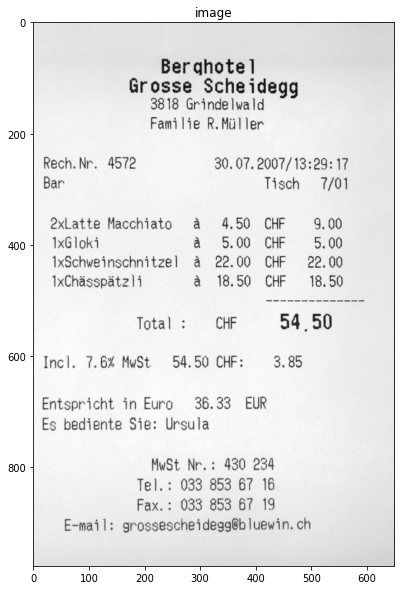

In [21]:
show(cropped)

In [22]:
def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 0)
    th = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    inverted = cv2.bitwise_not(th.copy(), th.copy())
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    dilated = cv2.dilate(inverted, kernel)
    return dilated

1846.0
(978, 650)


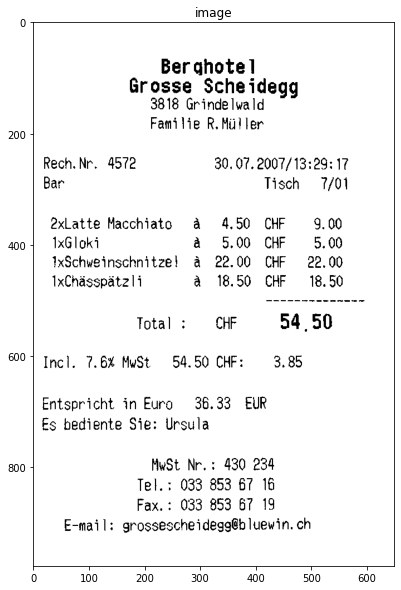

3930.0
(683, 1024)


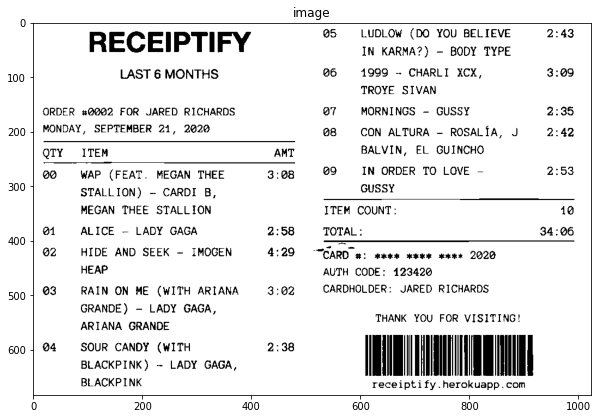

631769.5
(1067, 800)


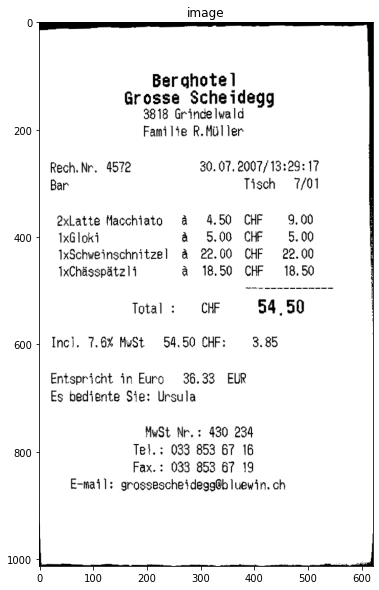

40274.5
(4000, 3000)


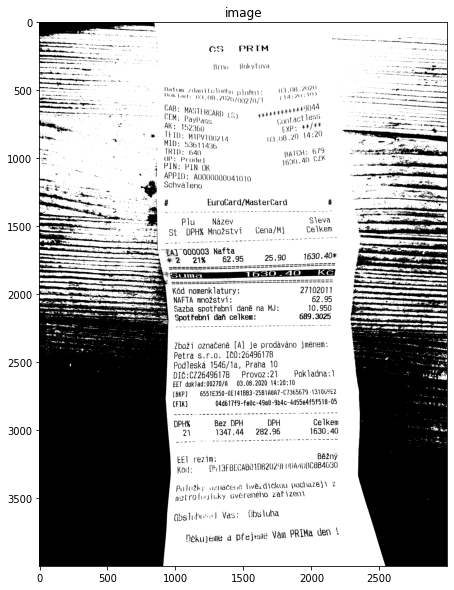

50934.0
(3001, 2577)


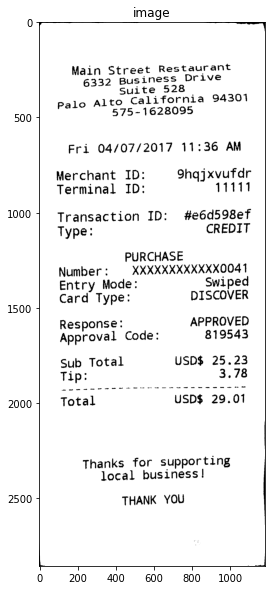

In [23]:
for image_name in ["receipt_clean.png", "receipt_creased.jpeg", "receipt_edges.jpeg",
                  "receipt_hard.jpg", "receipt_large.jpeg"]:
    #image_name = 'receipt_edges.jpeg'
    original = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    processed = preprocess_image(original)
    corners = find_corners_of_largest_polygon(processed)
    
    _, underlying = cv2.threshold(original, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    show(crop_and_warp(underlying, corners))

In [24]:
original = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(original)
corners = find_corners_of_largest_polygon(processed)

cropped_original = crop_and_warp(original, corners)
show("result", cropped_original, "gray")

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


In [ ]:
for name in ["receipt_clean.png"]:
    original = cv2.imread(f"images/{name}", cv2.IMREAD_GRAYSCALE)
    processed = preprocess_image(original.copy())
    corners = find_corners_of_largest_polygon(processed.copy())

    underlying = cv2.imread(f"images/{name}", cv2.IMREAD_GRAYSCALE)
    _, th = cv2.threshold(underlying.copy(), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    result = crop_and_warp(th.copy(), corners)
    show("result", result.copy(), "gray")

In [ ]:
for image_name in ["receipt_clean.png", "receipt_creased.jpeg", "receipt_edges.jpeg",
                  "receipt_hard.jpg", "receipt_large.jpeg"]:
    img = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    #img = cv2.GaussianBlur(img, (5, 5), 0)
    _, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    inverse = cv2.bitwise_not(otsu, otsu)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    dilated = cv2.dilate(inverse, kernel)
    inverse = cv2.bitwise_not(dilated, dilated)
    cropped_otsu = crop_and_warp(dilated, corners)
    show("result", cropped_otsu, "gray")

In [ ]:
for image_name in ["receipt_clean.png", "receipt_creased.jpeg", "receipt_edges.jpeg",
                  "receipt_hard.jpg", "receipt_large.jpeg"]:
    img = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (9, 9), 0)
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    inverse = cv2.bitwise_not(th, th)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    eroded = cv2.erode(inverse, kernel)
    dilated = cv2.dilate(eroded, kernel)
    inverse = cv2.bitwise_not(dilated, dilated)
    cropped = crop_and_warp(dilated, corners)
    show("result", cropped, "gray")


In [ ]:
for image_name in ["receipt_large.jpeg"]:
    a = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    show("a", a)
    b = cv2.GaussianBlur(a, (9, 9), 0)
    c = cv2.adaptiveThreshold(b, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    d = cv2.bitwise_not(c, c)
    show("d", d)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    e = cv2.erode(d, kernel)
    f = cv2.dilate(e, kernel)
    g = cv2.bitwise_not(f, f)
    show("g", g)
    cropped = crop_and_warp(g, corners)
    show("result", cropped, "gray")
